In [12]:
from dotenv import load_dotenv

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from typing import TypedDict
from openai import OpenAI
import subprocess
import textwrap
from langchain.chat_models import init_chat_model
from typing_extensions import Annotated
import operator
import base64

# import .env variables
load_dotenv()

# initialize the LLM
llm = init_chat_model("openai:gpt-4o-mini")

class State(TypedDict):
  # the video input file
  video_file: str
  # the audio input file
  audio_file: str
  # the transcription of the video
  transcription: str
  # the summary of the chunks of transcription
  summaries: Annotated[list[str], operator.add]
  # the final summary of the transcription
  final_summary: str
  # thumbnail file names
  thumbnail_sketches: Annotated[list[str], operator.add]
  # thumbnail prompts
  thumbnail_prompts: Annotated[list[str], operator.add]

In [13]:
# extract the audio of mp4 file using ffmpeg
def extract_audio(state: State):

  # converts mp4 video into mp3 audio file
  output_file = state["video_file"].replace("mp4", "mp3")

  # ffmpeg command to extract audio from video
  # e.g. $ ffmpeg -i input.mp4 output.avi
  command = [
    "ffmpeg",
    "-i",
    state["video_file"],
    # filter to the audio
    "-filter:a",
    # speed up video (doesn't change the quality of transcription but cheaper since shorter video)
    "atempo=2.0",
    # answers yes to all prompts (do you want to overwrite the file if it already exists)
    "-y",
    output_file
  ]

  # run the command in the terminal
  subprocess.run(command)

  # update the 'audio_file' state
  return {
    "audio_file": output_file
  }

# transcribe the audio file using whisper
def transcribe_audio(state: State):

  client = OpenAI()
  
  # open the audio file
  # state["audio_file"] is the path to the audio file
  # file requires a file-like object
  # 'rb' - open the file for reading in binary mode
  with open(state["audio_file"], "rb") as audio:
    # create the transcription
    transcription = client.audio.transcriptions.create(
      # required - 'file', 'model'
      # optional - 'response_format', 'language', etc...
      file=audio,
      model="whisper-1",
      response_format="text",
      # The language of the input audio. 
      # Supplying the input language in ISO-639-1 (e.g. en) format will improve accuracy and latency.
      language="en",
      # helps the model to understand the context of the video
      prompt="Tottenham, Arsenal, North London Derby"
    )

  # update the 'transcription' state
  return {
    "transcription": transcription
  }

# dispatch the transcription into chunks to 'summarize_chunk' node
def dispatch_summarizers(state: State):
  transcription = state["transcription"]
  chunks = []

  # creates a list of chunks with appropriate id
  # textwrap - split the transcript into chunks of defined length
  for i, text in enumerate(textwrap.wrap(transcription, 500)):
    chunks.append({"id": i + 1, "text": text})

  # send the chunks to the 'summarize_chunk' node in parallel
  return [Send("summarize_chunk", chunk) for chunk in chunks]

# summarize each chunk of transcription
def summarize_chunk(chunk):
  chunk_id = chunk["id"]
  text = chunk["text"]

  # ask the LLM to summarize the text
  response = llm.invoke(
    f"""
    Please summarize the following text.

    Text: {text}
    """
  )
  
  # format the summary
  summary = f"[Chunk {chunk_id}] {response.content}"

  # update the 'summaries' state
  return {
    "summaries": [summary]
  }

# create the final summary of the transcription
def mega_summary(state: State):

  # combine all the summaries into one string
  all_summaries = "\n".join(state["summaries"])

  prompt = f"""
    You are given multiple summaries of different chunks from a video transcription.

    Please create a comprehensive final summary that combines all the key points.

    Individual summaries: {all_summaries} 
  """

  response = llm.invoke(prompt)

  return {
    "final_summary": response.content
  }

# dispatch the final summary to the 'dispatch_sketchers' node
def dispatch_artists(state: State):
  # send the final summary to the 'generate_thumbnails' node in parallel
  # n - number of thumbnails to generate
  n = 5
  return [Send("generate_thumbnails", {"id": i + 1, "summary": state["final_summary"]}) for i in range(n)]

# create the sketches of the final summary
def generate_thumbnails(args):
  concept_id = args["id"]
  summary = args["summary"]

  prompt = f"""
    Based on this video summary, create a detailed visual prompt for a Youtube thumbnail.

    Create a detailed prompt for generating a thumbnail image that would attract viewers. Include:
      - Main visual elements
      - Color scheme
      - Text overlay suggestions
      - Overall composition

    Summary: {summary}
  """

  response = llm.invoke(prompt)
  thumbnail_prompt = response.content

  client = OpenAI()

  # generate the thumbnail
  result = client.images.generate(
    model="gpt-image-1",
    prompt=thumbnail_prompt,
    quality="low",
    moderation="low",
    size="auto"
  )

  # decode the image bytes
  image_bytes = base64.b64decode(result.data[0].b64_json)

  file_name = f"thumbnail_{concept_id}.jpg"

  # save the image to the local directory
  with open(file_name, "wb") as f:
    f.write(image_bytes)

  # update the 'thumbnail_sketches' and 'thumbnail_prompts' states
  return {
    "thumbnail_sketches": [file_name],
    "thumbnail_prompts": [thumbnail_prompt]
  }

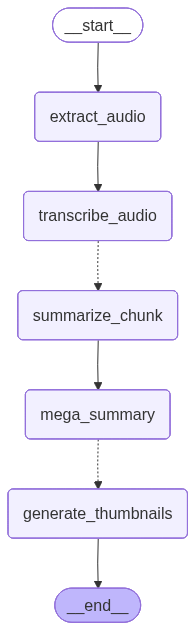

In [14]:

# create the state graph
graph_builder = StateGraph(State)

# create the nodes using the predefined functions
graph_builder.add_node("extract_audio", extract_audio)
graph_builder.add_node("transcribe_audio", transcribe_audio)
graph_builder.add_node("summarize_chunk", summarize_chunk)
graph_builder.add_node("mega_summary", mega_summary)
graph_builder.add_node("generate_thumbnails", generate_thumbnails)

# create the edges between the nodes
graph_builder.add_edge(START, "extract_audio")
graph_builder.add_edge("extract_audio", "transcribe_audio")
graph_builder.add_conditional_edges("transcribe_audio", dispatch_summarizers, ["summarize_chunk"])
graph_builder.add_edge("summarize_chunk", "mega_summary")
graph_builder.add_conditional_edges("mega_summary", dispatch_artists, ["generate_thumbnails"])
graph_builder.add_edge("generate_thumbnails", END)

# compile the graph
graph = graph_builder.compile()

graph

In [15]:
graph.invoke({"video_file": "video.mp4"})

ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.3.19.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --e

{'video_file': 'video.mp4',
 'audio_file': 'video.mp3',
 'transcription': "Always raucous, always locally enthralling, now universally embraced, this tight corner of capital city real estate becomes today the Premier League property of the wandering world. Shoots in space! Oh! He rolls! Oh, what a shot! Was it to get there? What a goal! Here is Harry Kane for Tottenham! Oh, what a goal! It's simply a very, very big football match. Arsenal beat Tottenham Hotspur is one of the fiercest and most famous rivalries in football. Two clubs with proud histories and identities were bound together by the battle for local bragging rights in North London and far beyond. White Hart Lane witnessed the genius of Hoddle, Gascoigne, Bale and Kane. What a strike from Harry Kane! And the hybrid crowd watched in awe at the class of Liam Brady, Ian Wright, Danny Spirkham and Thierry Henry. There was just no stopping him. Trust Thierry Henry to have a say on Tommy Day. The ever-changing power dynamic and dif